Tenga en cuenta que el archivo `unet_model.py` utilizado en este tutorial es solo para demostración.
El autor original de `unet_model.py` es Supervisely.
Consultar README de pv-vision y `unet_model.py` para conocer los términos de uso.
Puede cambiar el modelo aquí con otros pesos para uso personal.


In [1]:
# Importar librerías

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import requests
import copy
from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os

# Importar Model Handler
from pv_vision.nn import ModelHandler

In [2]:
### FUNCIONES
def get_annotation_masks(annotations):
    """ Convierte las máscaras de anotaciones en tensores de PyTorch redimensionados a 256x256 
    
    Parametros:
                annotations -- Lista de máscaras de anotaciones de NumPy
    Retorna:
                Lista de tensores de PyTorch redimensionados a 256x256
    """
    masks_each = []
    for annotation in annotations:
        # cross = (annotation == 2)
        # busbar = (annotation == 4)
        # crack = (annotation == 3)
        # dark = (annotation == 1)
        busbar = (annotation == 1) #1
        crack = (annotation == 2) #2
        cross = (annotation == 3) #3
        dark = (annotation == 4)  #4
        # Convertir las máscaras de NumPy a tensores de PyTorch
        cross_tensor = torch.from_numpy(cross.astype(np.float32))
        busbar_tensor = torch.from_numpy(busbar.astype(np.float32))
        crack_tensor = torch.from_numpy(crack.astype(np.float32))
        dark_tensor = torch.from_numpy(dark.astype(np.float32))
        
        # Apilar las máscaras
        stacked_masks = torch.stack([busbar_tensor, crack_tensor, cross_tensor, dark_tensor], dim=0)
        
# Redimensionar las máscaras apiladas: Se añade una dimensión batch al principio para usar interpolate
        stacked_masks = stacked_masks.unsqueeze(0)
        resized_masks = torch.nn.functional.interpolate(stacked_masks, size=(256, 256), mode='nearest')
        
        # Eliminar la dimensión batch y agregar el tensor redimensionado a la lista
        masks_each.append(resized_masks.squeeze(0))
    return masks_each


def show_comparison(pred_mask, true_mask, class_names):
    """ Muestra las máscaras predichas y verdaderas para cada clase en una fila de subgráficos

    Parametros:
                pred_mask -- Máscaras predichas
                true_mask -- Máscaras verdaderas
                class_names -- Nombres de las clases
    """
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, 2, figsize=(10, num_classes * 5))
    
    for i, class_name in enumerate(class_names):
        # Predicted mask for the class
        axes[i, 0].imshow(pred_mask[i], cmap='gray')
        axes[i, 0].set_title(f'Predicted Mask - {class_name}')
        axes[i, 0].axis('off')
        
        # True mask for the class
        axes[i, 1].imshow(true_mask[i], cmap='gray')
        axes[i, 1].set_title(f'True Mask - {class_name}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Definir la transformación de las imágenes que se pasará al manejador del modelo
transform = transforms.Compose([
    # Convertir la imagen a un tensor de PyTorch y escalar los valores de los píxeles entre 0 y 1
    transforms.ToTensor(),
    # Normalizar cada canal de color de la imagen. Los valores de la media y la desviación estándar se especifican para cada canal (RGB). 
    # Estos valores son los valores de media y desviación estándar del conjunto de datos ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Definir una clase personalizada que hereda de Dataset
class myDataset(Dataset):
    # El método de inicialización se llama cuando se crea una instancia de la clase
    def __init__(self, images, transform):
        # Guardar las imágenes y la transformación como atributos de la instancia
        self.images = images
        self.transform = transform

    # El método __len__ devuelve el número de elementos en el conjunto de datos
    def __len__(self):
        return len(self.images)

    # El método __getitem__ se utiliza para obtener un elemento del conjunto de datos
    def __getitem__(self, idx):
        # Redimensionar la imagen al tamaño deseado
        image = cv.resize(self.images[idx], (256, 256))
        # Aplicar la transformación a la imagen
        image = self.transform(image)
        
        # Devolver la imagen transformada
        return image

# Calcular el IoU para una clase específica
def calculate_iou(pred_mask, true_mask):
    """ Calcula el Índice de Jaccard (IoU) para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Índice de Jaccard para la clase
    """
    intersection = torch.logical_and(pred_mask, true_mask).sum().item()
    union = torch.logical_or(pred_mask, true_mask).sum().item()
    if union == 0:
        return float('nan')  # Si no hay ningún píxel verdadero o predicho en esta clase, devolver NaN
    return intersection / union

# Función para calcular Precision
def calculate_precision(pred_mask, true_mask):
    """ Calcula la Precisión para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Precisión para la clase
    """
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    predicted_positive = pred_mask.sum().item()
    if predicted_positive == 0:
        return float('nan')  # Si no hay ningún píxel predicho positivo, devolver NaN
    return true_positive / predicted_positive

# Función para calcular Recall
def calculate_recall(pred_mask, true_mask):
    """ Calcula la Sensibilidad (Recall) para una clase específica

    Parametros:
                pred_mask -- Máscara predicha para la clase
                true_mask -- Máscara verdadera para la clase
    Retorna:
                Sensibilidad (Recall) para la clase
    """
    true_positive = torch.logical_and(pred_mask, true_mask).sum().item()
    actual_positive = true_mask.sum().item()
    if actual_positive == 0:
        return float('nan')  # Si no hay ningún píxel verdadero positivo, devolver NaN
    return true_positive / actual_positive

# Función para calcular F1 Score
def calculate_f1_score(precision, recall):
    """ Calcula el F1 Score a partir de la Precisión y la Sensibilidad (Recall)

    Parametros:  
                precision -- Precisión  
                recall -- Sensibilidad (Recall)  
    Retorna:  
                F1 Score
    """
    if np.isnan(precision) or np.isnan(recall) or (precision + recall) == 0:
        return float('nan')  # Si alguna de las métricas es NaN o la suma es 0, devolver NaN
    return 2 * (precision * recall) / (precision + recall)

# Función para evaluar las predicciones y calcular todas las métricas
def evaluate_predictions(pred_masks, true_masks):
    """ Evalua las predicciones y calcula las métricas de evaluación
    
    Parametros:
                pred_masks: Lista de máscaras predichas
                true_masks: Lista de máscaras verdaderas
    Retorna:
                Diccionario de métricas con las métricas de evaluación para cada
    """
    ious = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    precisions = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    recalls = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    f1_scores = { 'busbar': [], 'crack': [], 'cross': [], 'dark': [] }
    
    for pred_mask, true_mask in zip(pred_masks, true_masks):
        for i, class_name in enumerate(['busbar', 'crack', 'cross', 'dark']):
            iou = calculate_iou(pred_mask[i], true_mask[i])
            precision = calculate_precision(pred_mask[i], true_mask[i])
            recall = calculate_recall(pred_mask[i], true_mask[i])
            f1_score = calculate_f1_score(precision, recall)
            
            ious[class_name].append(iou)
            precisions[class_name].append(precision)
            recalls[class_name].append(recall)
            f1_scores[class_name].append(f1_score)
    
    metrics = {}
    for class_name in ious:
        metrics[class_name] = {
            'IoU': np.nanmean(ious[class_name]),
            'Precision': np.nanmean(precisions[class_name]),
            'Recall': np.nanmean(recalls[class_name]),
            'F1 Score': np.nanmean(f1_scores[class_name])
        }
    return metrics

In [3]:

# Carpeta de imágenes
val_imgs_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/DatasetFinal/resize/img'
#val_imgs_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/img'
#D:\Documentos\Universidad de Cuenca\Trabajo de Titulación\FullDataset\SuperMerge\img

# Carpeta de anotaciones
#val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/CellAnotation_no_humanMasks/dataset_cells/annotations'
val_annotations_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/DatasetFinal/resize/ann'
#val_annotations_path = 'D:/Documentos/PV_Vision/crack_segmentation/crack_segmentation/val/new_ann_v1'
images_val = [cv.imread(file) for file in list_images(val_imgs_path)]           #imágenes de validación
ann_val = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in list_images(val_annotations_path)]       # anotaciones de validación
# Verificar que las imágenes se cargaron correctamente
print(f'Número de imágenes de validación: {len(images_val)}')
print(f'Número de anotaciones de validación: {len(ann_val)}')


Número de imágenes de validación: 96
Número de anotaciones de validación: 96


In [4]:
# Transformación para redimensionar las imágenes a 256x256 y convertirlas a tensores de PyTorch.
resize = transforms.Compose([transforms.Resize((256, 256)), transforms.PILToTensor()])

# Mapa de colores para las diferentes clases de máscaras.
color_map = {
    'dark': (68, 114, 148),
    'cross': (77, 137, 99),
    'crack': (165, 59, 63),
    'busbar': (222, 156, 83)
}

# Función para obtener las máscaras de las predicciones del modelo.
def get_masks(masks_raw):
    # Se creó una lista vacía para almacenar las máscaras.
    masks_each = []
    # Se aplicó la función softmax a las predicciones del modelo y se obtuvo la clase con la mayor probabilidad para cada píxel.
    masks_all = torch.nn.functional.softmax(torch.from_numpy(masks_raw), dim=1).argmax(dim=1)
    # Para cada máscara en masks_all, se crearon máscaras booleanas para cada clase y se añadieron a la lista masks_each.
    for masks in masks_all:
        busbar = masks==1
        crack = masks==2
        cross = masks==3
        dark = masks==4
        masks_each.append(torch.dstack([busbar, crack, cross, dark]).permute(2, 0, 1))
    return masks_each

# Se definió una función para dibujar las máscaras sobre las imágenes.
def draw_mask(img, masks, colors=color_map, alpha=0.6):
    # Se convirtió la imagen a un objeto de la clase Image de PIL y se redimensionó.
    img = Image.fromarray(img)
    img = resize(img)
    # Se dibujaron las máscaras sobre la imagen con la opacidad especificada y se devolvió la imagen resultante.
    combo = draw_segmentation_masks(img, masks, alpha=alpha, colors=[colors[key] for key in ['busbar', 'crack', 'cross', 'dark']])
    return F.to_pil_image(combo)

In [6]:
# Se define una función para crear un modelo DeepLab preentrenado.
def DeepLab_pretrained(num_classes):
    # Se carga el modelo DeepLab con una arquitectura ResNet50 preentrenada.
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

    # Se reemplaza el clasificador del modelo con un nuevo clasificador DeepLabHead.
    # El nuevo clasificador tiene 2048 características de entrada y 'num_classes' características de salida.
    deeplab.classifier = DeepLabHead(2048, num_classes)

    # Se devuelve el modelo modificado.
    return deeplab

In [ ]:
                ## Celda para DeepLab ##
imgset = myDataset(images_val, transform)

# Definición del dispositivo en el que se ejecutará el modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')

# Crea una instancia del modelo DeepLab con 5 canales de salida
model = DeepLab_pretrained(5)

# Envuelve el modelo en un objeto DataParallel
model = DataParallel(model).to(device)

# Cargar los pesos del modelo entrenado
weight_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/PesosGColab/deeplab.pt'
#model.load_state_dict(torch.load(weight_path, map_location=device))

# Coloca el modelo en modo de evaluación
#model.eval()

# Iniciar el manejador del modelo (ModelHandler) para DeepLab
modelhandler = ModelHandler(
    model=model,
    model_output='out',
    test_dataset=imgset,
    predict_only=True,
    batch_size_val=2,
    device=device,
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    save_name='deeplab_cell_prediction'
)
modelhandler.load_model(weight_path)
# Ejecución del modelo en el conjunto de datos de prueba
masks = modelhandler.predict(save=True)

In [10]:
from efficientunet import EfficientNet

unet = EfficientNet.from_name('efficientnet-b5', n_classes=5, pretrained=False)

In [16]:
                ## Celda para U-Net ##
# Crea el dataset
imgset = myDataset(images_val, transform)
# Carpeta de pesos del modelo
#weight_path = 'D:/Documentos/PV_Vision/Neural_Network_W/crack_segmentation/unet_oversample_low_final_model_for_paper/model.pt'
weight_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/PesosGColab/unetv32.pt'
# Definición del dispositivo en el que se ejecutará el modelo. 

# Si hay una GPU disponible, se utilizará.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo: {device}')
# Crea una instancia del modelo U-Net con 5 canales de salida. 
# Número de canales de salida = al número de clases
unet = construct_unet(5)
# Se "envuelve" el modelo en un objeto DataParallel. 
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

# Iniciar el manejador del modelo (ModelHandler). 
# Este objeto se encargará de la gestión del modelo, incluyendo la carga de los datos, 
# la ejecución del modelo y el almacenamiento de los resultados.
modelhandler = ModelHandler(
    # El modelo que se va a utilizar.
    model=unet,
    #model_output='out_deeplab',
    # El conjunto de datos que se utilizará para las pruebas.
    test_dataset=imgset,
    # Indica que sólo se realizarán predicciones, no se entrenará el modelo.
    predict_only=True,
    # El tamaño del lote que se utilizará durante la validación. En este caso, se procesarán 2 imágenes a la vez.
    batch_size_val=2,
    # El dispositivo en el que se ejecutará el modelo.
    device=device,
    # El directorio donde se guardarán los resultados. 
    save_dir='D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Modulos/Celdas/output',
    # El nombre que se utilizará para guardar los resultados. 
    save_name='Unetv32_cell_prediction_val'
)
# Cargar los pesos del modelo desde el archivo especificado por 'weight_path'.
# Esto permite utilizar un modelo que ha sido entrenado previamente, en lugar de tener que entrenar el modelo desde cero.
modelhandler.load_model(weight_path)

# Ejecución del modelo en el conjunto de datos de prueba.
# Esto generará predicciones para cada imagen en el conjunto de datos.
masks = modelhandler.predict(save=True)

Dispositivo: cuda:0


100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


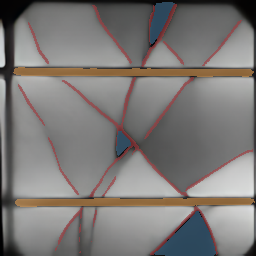

In [17]:
noCell = 27
true_masks = get_annotation_masks(ann_val)
# Se obtienen las máscaras de las predicciones del modelo.
masks_each = get_masks(masks)
# Se dibujan las máscaras sobre las imágenes originales.
draw_mask(images_val[noCell], masks_each[noCell])

In [18]:
# Calcular las métricas para las predicciones del modelo.
metrics = evaluate_predictions(masks_each, true_masks)

print("Métricas para las predicciones del modelo:")

for class_name, class_metrics in metrics.items():
    print(f'{class_name}:')
    for metric_name, value in class_metrics.items():
        print(f'  {metric_name}: {value:.4f}')

Métricas para las predicciones del modelo:
busbar:
  IoU: 0.8325
  Precision: 0.9151
  Recall: 0.9031
  F1 Score: 0.9083
crack:
  IoU: 0.4937
  Precision: 0.6794
  Recall: 0.6465
  F1 Score: 0.6557
cross:
  IoU: 0.0000
  Precision: 0.0000
  Recall: nan
  F1 Score: nan
dark:
  IoU: 0.7969
  Precision: 0.8714
  Recall: 0.9066
  F1 Score: 0.9064


C:\Users\Compustore\AppData\Local\Temp\ipykernel_21148\852043561.py:188: RuntimeWarning: Mean of empty slice
  'Recall': np.nanmean(recalls[class_name]),
C:\Users\Compustore\AppData\Local\Temp\ipykernel_21148\852043561.py:189: RuntimeWarning: Mean of empty slice
  'F1 Score': np.nanmean(f1_scores[class_name])


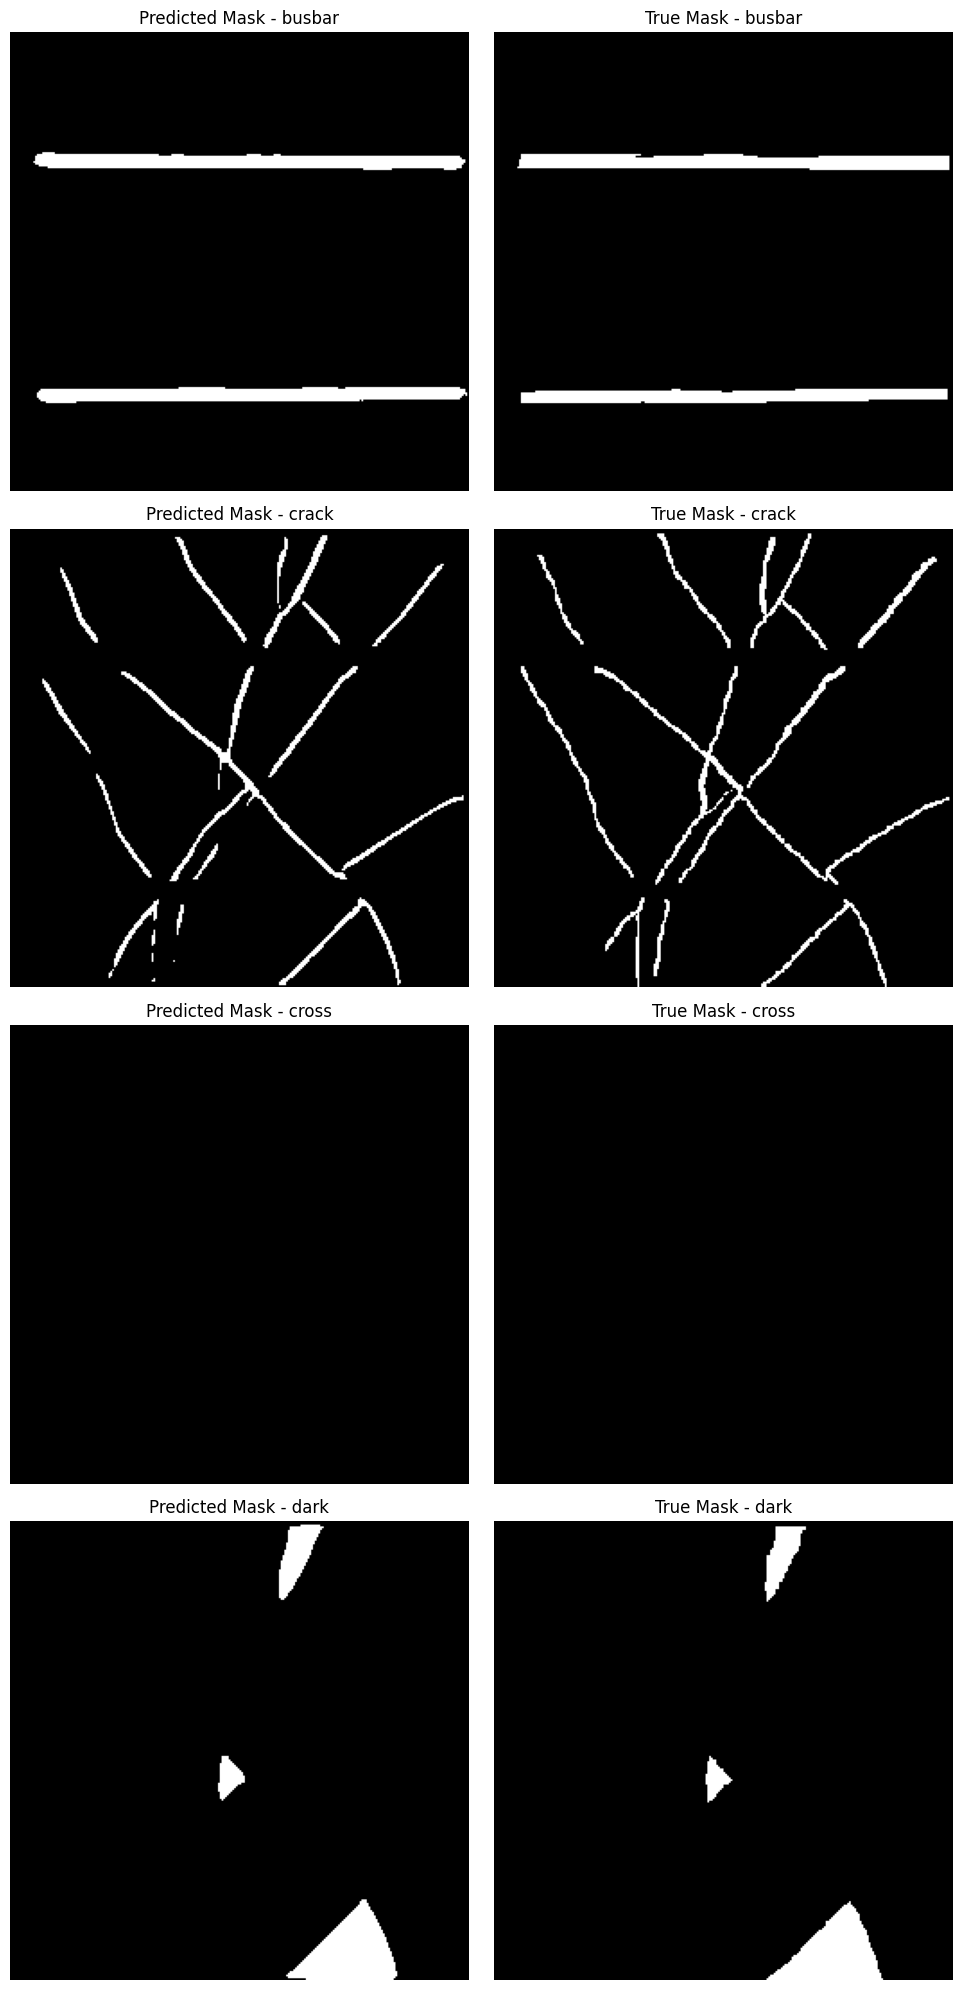

In [19]:
# Comparar una máscara predicha con la máscara verdadera
pred_mask = masks_each[noCell]  # Primera predicción del modelo
true_mask = true_masks[noCell]  # Primera máscara de anotación

# Nombres de las clases
class_names = ['busbar', 'crack', 'cross', 'dark']

# Mostrar la comparación
show_comparison(pred_mask, true_mask, class_names)

Para analizar el porcentaje de área inactiva de una celda se requiere crear una imagen de anotaciones `annImage` con las máscaras de las clases `crack` y `busbar`, esta imagen de anotaciones debe ser almacenada  con el mismo nombre que la imagen de la celda, para facilitar el posterior análisis. Tal vez lo más sencillo sea copiar la imagen original de la celda y almacenarla en un nuevo directorio con un nuevo nombre, el nombre debería asignarse de dorma automática.

In [21]:
# Creación de imagen de anotaciones `annImage` con las máscaras `crack` y `busbar` de las predicciones
images_path = 'D:/Documentos/Universidad de Cuenca/Trabajo de Titulación/Predicciones/Salidas'
os.makedirs(f'{images_path}/ann', exist_ok=True)
os.makedirs(f'{images_path}/image', exist_ok=True)


# Valores para las clases. 'background': 0, 'busbar': 10, 'crack': 100
class_values = [0, 10, 100]

# Suponiendo que tienes múltiples celdas
for idx, mask in enumerate(masks_each):
    annImage = np.zeros(mask[0].shape, dtype=np.uint8)
    annImage[mask[0]] = class_values[1]  # busbar
    annImage[mask[1]] = class_values[2]  # crack

    annImage = cv.resize(annImage, (images_val[idx].shape[1], images_val[idx].shape[0]), 
                         interpolation=cv.INTER_NEAREST)
    cv.imwrite(f'{images_path}/ann/annImage{idx}.png', annImage)
    cv.imwrite(f'{images_path}/image/Image{idx}.png', images_val[idx])


Extracción de características de las grietas: porcentaje de área inactiva de la celda

In [23]:
from pv_vision.crack_analysis.crackcell import CrackCell
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
def analyze_cell(idx, img_path, ann_path, crack_inx=100, busbar_inx=10, busbar_num=3):
    img_path = f"{img_path}/images/Image{idx}.png"
    ann_path = f"{ann_path}/ann/annImage{idx}.png"
    crackcell = CrackCell(img_path, ann_path, crack_inx, busbar_inx, busbar_num)
    
    inactive_area, inactive_prop = crackcell.extract_inactive_area()
    crack_length = crackcell.extract_crack_length()
    brightness = crackcell.extract_brightness(mode='avg_inactive_only')
    features = crackcell.extract_features()

    # Opcional: almacenar resultados
    results = {
        "inactive_prop": inactive_prop,
        "crack_length": crack_length,
        "brightness": brightness,
        "features": features
    }
    return results


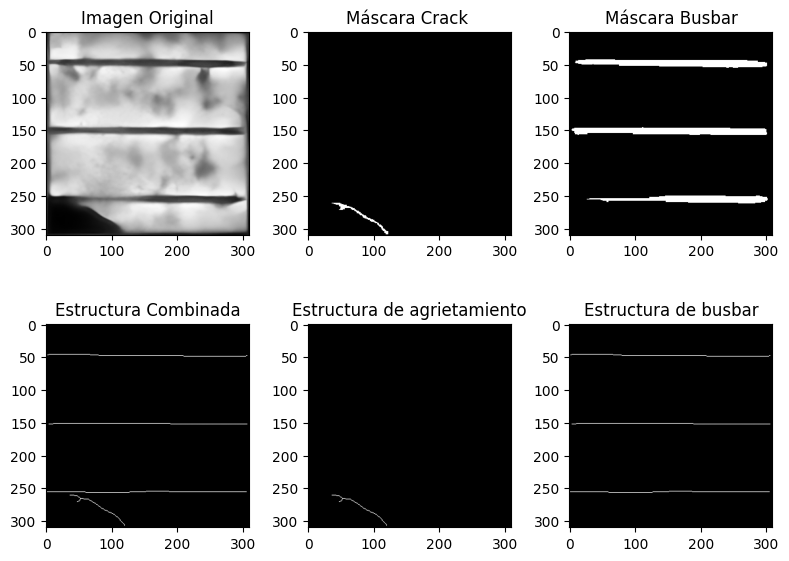

In [28]:
img_path = images_path + '/image/Image11.png'
ann_path = images_path + '/ann/annImage11.png'
# Crear una instancia de CrackCell
crackcell = CrackCell(img_path,
                      ann_path,
                      crack_inx = 100,
                      busbar_inx = 10,
                      busbar_num=3)

# Visualización de la imagen original y las máscaras de crack y busbar
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
axes[0, 0].imshow(crackcell.img, 'gray')
axes[0, 0].set_title('Imagen Original')
axes[0, 1].imshow(crackcell.crack, 'gray')
axes[0, 1].set_title('Máscara Crack ')
axes[0, 2].imshow(crackcell.busbar, 'gray')
axes[0, 2].set_title('Máscara Busbar')

axes[1, 0].imshow(crackcell.ske_merge, 'gray')
axes[1, 0].set_title('Estructura Combinada')
axes[1, 1].imshow(crackcell.ske_crack, 'gray')
axes[1, 1].set_title('Estructura de agrietamiento')
axes[1, 2].imshow(crackcell.ske_busbar, 'gray')
axes[1, 2].set_title('Estructura de busbar')

plt.tight_layout()

2.7117585848074923 % de la celda está inactiva
Grieta de 93 pixels de longitud 


{'inactive_prop': 0.027117585848074922,
 'crack_length': 93,
 'brightness_inactive_only': 0.09254059259928069}

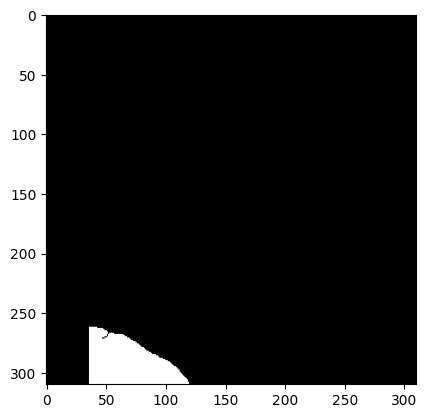

In [34]:
# Extracción del área inactiva
inactive_area, inactive_prop = crackcell.extract_inactive_area()
plt.imshow(inactive_area, "gray")
print("{} % de la celda está inactiva".format(inactive_prop*100))

# Extracción de la longitud de la grieta
crack_length = crackcell.extract_crack_length()
print("Grieta de {} pixels de longitud ".format(crack_length))

# Extracción del brillo
# Existen tres modos
# 1. avg_all: brillo promedio de toda la imagen
# 2. avg_inactive: brillo promedio de la región inactiva y trata el área actica como 1
# 3. avg_inactive_only: brillo promedio solo del área inactiva y devuelve 1 para las celdas intactas

brightness = crackcell.extract_brightness(mode='avg_inactive_only')
#brightness
# Extracción de todas las funciones a la vez
crackcell.extract_features()